In [1]:
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

In [2]:
# https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-2020-2024/wujg-7c2s/about_data
mta_gdf = gpd.read_file("../data/MTA Subway Hourly Ridership_ 2020-2024_20250426_manhattan_june_2024.geojson")
mta_gdf.set_geometry("geometry", inplace=True)
mta_gdf.head()

,fare_class_category,latitude,transit_mode,station_complex_id,longitude,station_complex,payment_method,ridership,transit_timestamp,transfers,borough,geometry
0,OMNY - Full Fare,40.747215,subway,319,-73.99336,28 St (1),omny,11.0,2024-06-01,0.0,Manhattan,POINT (-73.99336 40.74722)
1,Metrocard - Unlimited 7-Day,40.74408,subway,320,-73.99566,23 St (1),metrocard,3.0,2024-06-01,0.0,Manhattan,POINT (-73.99566 40.74408)
2,Metrocard - Other,40.799076,subway,441,-73.95182,"Central Park North (110 St) (2,3)",metrocard,2.0,2024-06-01,0.0,Manhattan,POINT (-73.95182 40.79908)
3,OMNY - Full Fare,40.730053,subway,407,-73.99107,Astor Pl (6),omny,213.0,2024-06-01,2.0,Manhattan,POINT (-73.99107 40.73005)
4,Metrocard - Fair Fare,40.750374,subway,318,-73.99106,"34 St-Penn Station (1,2,3)",metrocard,22.0,2024-06-01,0.0,Manhattan,POINT (-73.99106 40.75037)


In [3]:
tram_mask = mta_gdf.station_complex_id.isin(["TRAM1", "TRAM2"])
mta_gdf = mta_gdf.where(~tram_mask).dropna()

In [4]:
numeric_columns = ['latitude', 'station_complex_id', 'longitude', 'ridership', 'transfers']

for col in numeric_columns:
    mta_gdf[col] = pd.to_numeric(mta_gdf[col], errors='coerce')

In [5]:
res = mta_gdf.groupby(
    [pd.Grouper(key="transit_timestamp", freq="ME"), "station_complex_id", "station_complex", "geometry"],
    as_index=False
).agg(
    {"ridership": "sum"}
)

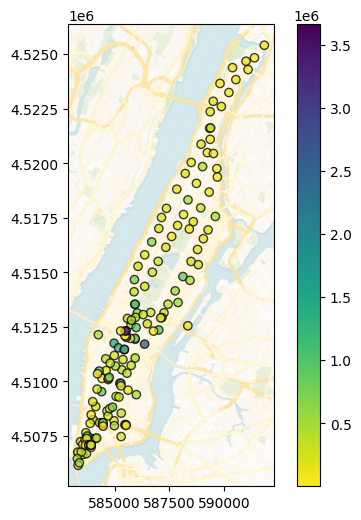

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

grouped_mta_gdf = gpd.GeoDataFrame(
    res,
    geometry=res.geometry,
    crs="EPSG:4326",
)
grouped_mta_gdf = grouped_mta_gdf.to_crs("EPSG:32618")
grouped_mta_gdf.plot(
    ax=ax,
    column="ridership",
    cmap="viridis_r",
    alpha=0.75,
    legend=True,
    edgecolor="black",
    # markersize="ridership",
    # legend_kwds={"label": "Ridership", "orientation": "horizontal"},
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
    }
)
ctx.add_basemap(ax, crs=grouped_mta_gdf.crs, source=ctx.providers.CartoDB.VoyagerNoLabels, attribution=False)

In [16]:
grouped_mta_gdf

,transit_timestamp,station_complex_id,station_complex,geometry,ridership
0,2024-06-30,8,"5 Av/59 St (N,R,W)",POINT (586649.713 4513156.424),298115.0
1,2024-06-30,9,"57 St-7 Av (N,Q,R,W)",POINT (586032.927 4513132.802),653130.0
2,2024-06-30,10,"49 St (N,R,W)",POINT (585745.331 4512600.555),525831.0
3,2024-06-30,13,"28 St (R,W)",POINT (585379.701 4510997.059),247139.0
4,2024-06-30,14,"23 St (R,W)",POINT (585330.184 4510530.974),379056.0
...,...,...,...,...,...
154,2024-06-30,628,"Fulton St (A,C,J,Z,2,3,4,5)",POINT (583914.494 4507061.504),1399.0
155,2024-06-30,628,"Fulton St (A,C,J,Z,2,3,4,5)",POINT (583914.273 4507081.041),1551084.0
156,2024-06-30,628,"Fulton St (A,C,J,Z,2,3,4,5)",POINT (583914.277 4507080.708),11923.0
157,2024-06-30,635,"South Ferry (1)/Whitehall St (R,W)",POINT (583325.388 4506152.602),741.0


In [25]:
import altair as alt
import geopandas as gpd
import pandas as pd
import json

# Load the dataset manually after downloading
gdf = gpd.read_file('../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Reproject to EPSG:4326 (lat/lng) for Altair compatibility
gdf = gdf.to_crs('EPSG:4326')

# Convert the GeoDataFrame to GeoJSON format
geojson_data = gdf.to_json()

# Normalize the GeoJSON data into a DataFrame
df = pd.json_normalize(json.loads(geojson_data)['features'])
df.columns

Index(['id', 'type', 'properties.featurecla', 'properties.scalerank',
       'properties.LABELRANK', 'properties.SOVEREIGNT', 'properties.SOV_A3',
       'properties.ADM0_DIF', 'properties.LEVEL', 'properties.TYPE',
       ...
       'properties.FCLASS_ID', 'properties.FCLASS_PL', 'properties.FCLASS_GR',
       'properties.FCLASS_IT', 'properties.FCLASS_NL', 'properties.FCLASS_SE',
       'properties.FCLASS_BD', 'properties.FCLASS_UA', 'geometry.type',
       'geometry.coordinates'],
      dtype='object', length=172)

In [26]:

# Convert 'geometry' column into a GeoJSON-like string for Altair
df['geometry'] = df['geometry.coordinates'].apply(lambda x: json.dumps(x))

# Create an Altair map chart using the normalized DataFrame
chart = alt.Chart(df).mark_geoshape(
    fill='lightblue',
    stroke='black'
).encode(
    color=alt.Color('properties.pop_est:Q', scale=alt.Scale(scheme='viridis')),  # Color based on population estimate
    tooltip=['properties.name:N', 'properties.pop_est:Q']  # Show name and population estimate in the tooltip
).project(
    type='identity'  # Identity projection (lat/lng coordinates)
)

# Display the chart
chart


alt.Chart(...)

In [ ]:
import altair as alt
import geopandas as gpd
import pandas as pd

"/Users/hunterlybbert/repos/uw-central/data_visualization/"
# Create a simple GeoDataFrame (replace this with your own GeoDataFrame)
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Convert GeoDataFrame to GeoJSON format
geojson_data = gdf.to_crs('EPSG:4326').to_json()  # Reproject to EPSG:4326 (lat/lng)

# Normalize the GeoJSON data into a DataFrame
df = pd.json_normalize(json.loads(geojson_data)['features'])

# Create an Altair map chart using the normalized DataFrame
chart = alt.Chart(df).mark_geoshape(
    fill='lightblue',
    stroke='black'
).encode(
    color=alt.Color('properties.pop_est:Q', scale=alt.Scale(scheme='viridis')),  # Color based on population estimate
    tooltip=['properties.name:N', 'properties.pop_est:Q']  # Show name and population estimate in the tooltip
).project(
    type='identity'  # Identity projection (lat/lng coordinates)
)

# Display the chart
chart


AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.